## load data

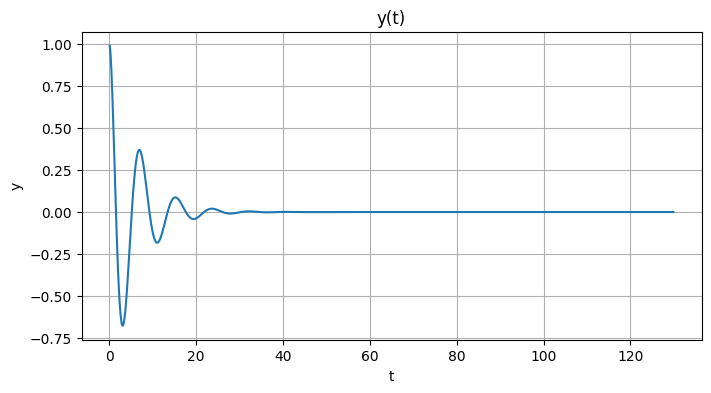

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルのパス
csv_path = "data/AC_waveform_data_11.5724.csv"

# データの読み込み
df = pd.read_csv(csv_path)

t_data = np.array(df.iloc[:, 0])
y_data = np.array(df.iloc[:, 1])

plt.figure(figsize=(8, 4))
plt.plot(t_data, y_data)
plt.xlabel('t')
plt.ylabel('y')
plt.title('y(t)')
plt.grid(True)
plt.show()

## Curve Fit

フィッティングで得られた最適パラメータ:
      A1: 1.2106
 lambda1: -0.6210
  omega1: 0.8538
    phi1: 0.2024
      A2: 1.2528
 lambda2: -0.1730
  omega2: 0.7505
    phi2: 2.4910


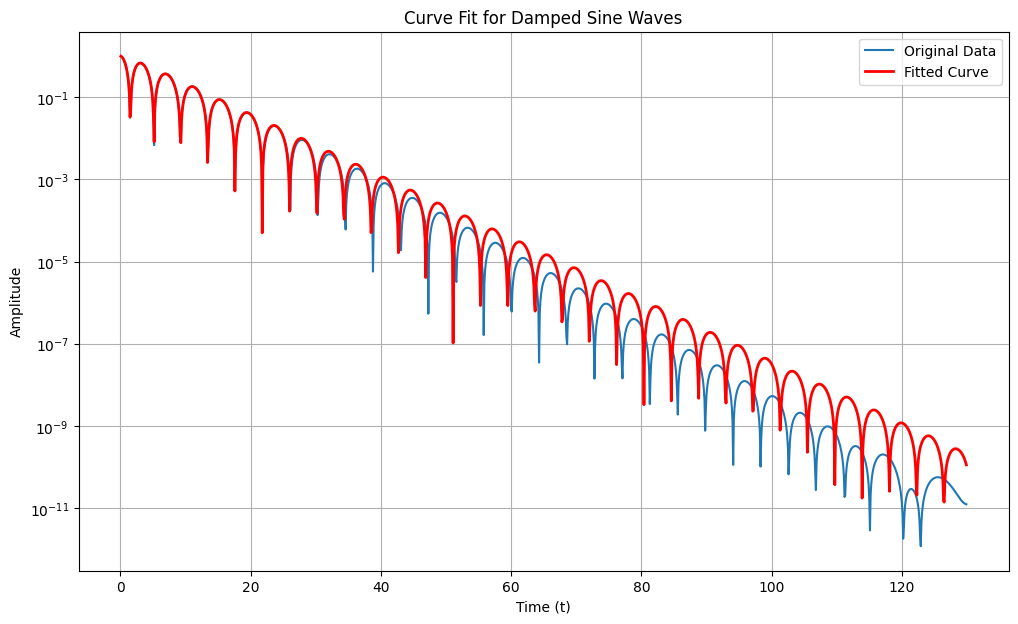

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_func(t, A1, lambda1, omega1, phi1, A2, lambda2, omega2, phi2):
    """
    フィッティング対象の関数：2つの減衰正弦波の和
    f(t) = A1*exp(lambda1*t)*sin(omega1*t+phi1) + A2*exp(lambda2*t)*sin(omega2*t+phi2)
    """
    term1 = A1 * np.exp(lambda1 * t) * np.sin(omega1 * t + phi1)
    term2 = A2 * np.exp(lambda2 * t) * np.sin(omega2 * t + phi2)
    return term1 + term2

# --- 1. データの準備 ---
# (オプション) サンプルデータの生成
# 実際には、この部分をご自身のデータ読み込み処理に置き換えてください。
# # 例: t_data, y_data = np.loadtxt('my_waveform_data.csv', delimiter=',', unpack=True)
# p_true = [1.5, -0.1, 5.0, np.pi/4, 1.0, -0.2, 12.0, np.pi/2] # 真のパラメータ
# t_data = np.linspace(0, 20, 500)
# # ノイズを加えた実データ（のつもり）
# y_data = fit_func(t_data, *p_true) + 0.15 * np.random.normal(size=t_data.size)


# --- 2. カーブフィッティングの実行 ---
# パラメータの初期推測値 (p0)
# 良い初期値を与えることがフィッティング成功の鍵となります。
# データを見て、おおよその値を推測します。
initial_guess = [
    1.0,  # A1
    -0.2116451411183, # lambda1
    0.7391984327078,  # omega1
    0,    # phi1
    0.8,  # A2
    -0.217234709569, # lambda2
    0.736312554, # omega2
    0     # phi2
]

# パラメータの境界 (bounds) を設定 (オプションですが推奨)
# A > 0, lambda < 0 など、物理的な制約を設けることで収束しやすくなります。
bounds = (
    [0, -np.inf, 0, -2*np.pi, 0, -np.inf, 0, -2*np.pi], # 下限
    [np.inf, 0, np.inf, 2*np.pi, np.inf, 0, np.inf, 2*np.pi]  # 上限
)

try:
    # curve_fit を実行
    popt, pcov = curve_fit(
        fit_func,
        t_data,
        y_data,
        p0=initial_guess,
        bounds=bounds,
        maxfev=10000 # 計算回数の上限を増やす
    )

    # --- 3. 結果の表示 ---
    print("フィッティングで得られた最適パラメータ:")
    param_names = ['A1', 'lambda1', 'omega1', 'phi1', 'A2', 'lambda2', 'omega2', 'phi2']
    for name, value in zip(param_names, popt):
        print(f"{name:>8s}: {value:.4f}")

    # --- 4. 結果のプロット ---
    plt.figure(figsize=(12, 7))
    plt.semilogy(t_data, np.abs(y_data), label='Original Data')
    plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
    plt.title('Curve Fit for Damped Sine Waves')
    plt.xlabel('Time (t)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"フィッティングに失敗しました: {e}")
    print("初期推測値(p0)や境界(bounds)を見直してください。")

(0.17, 0.23)

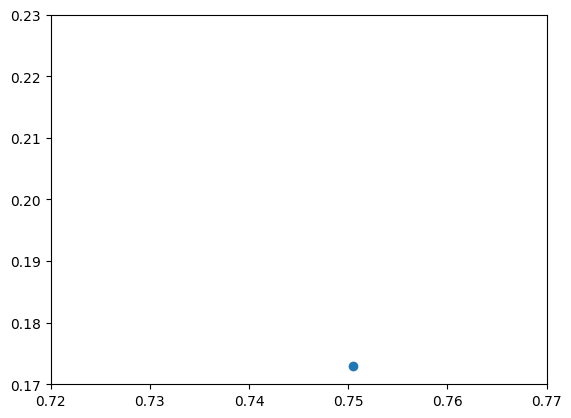

In [3]:
reqnm = [abs(popt[2]), abs(popt[6])]
imqnm = [abs(popt[1]), abs(popt[5])]
plt.plot(reqnm, imqnm, 'o')
plt.xlim(0.72, 0.77)
plt.ylim(0.17, 0.23)

Generating frames...
フィッティングで得られた最適パラメータ:
      A1: 1.2106
 lambda1: -0.6210
  omega1: 0.8538
    phi1: 0.2024
      A2: 1.2528
 lambda2: -0.1730
  omega2: 0.7505
    phi2: 2.4910


TypeError: close() argument must be a Figure, an int, a string, or None, not <class 'list'>

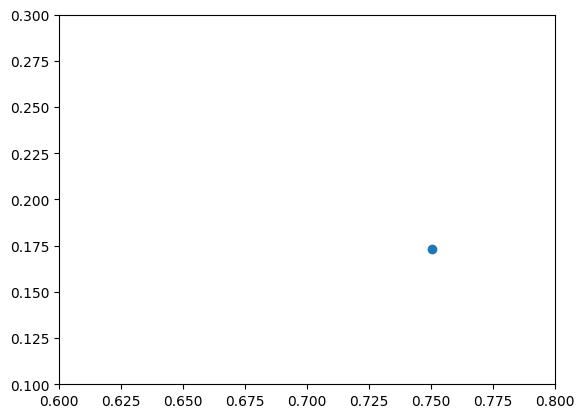

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# 1. アニメーションのパラメータ設定
num_frames = 100  # フレーム数
frame_duration = 10  # 各フレームの表示時間（ミリ秒）

# 2. フレームを保存するディレクトリの作成
output_dir = "animation_frames"
os.makedirs(output_dir, exist_ok=True)

# 3. 各フレームの画像を生成して保存
print("Generating frames...")
for i in range(num_frames):

    try:
        # curve_fit を実行
        popt, pcov = curve_fit(
            fit_func,
            t_data[10*i:],
            y_data[10*i:],
            p0=initial_guess,
            bounds=bounds,
            maxfev=10000 # 計算回数の上限を増やす
        )

        # --- 3. 結果の表示 ---
        print("フィッティングで得られた最適パラメータ:")
        param_names = ['A1', 'lambda1', 'omega1', 'phi1', 'A2', 'lambda2', 'omega2', 'phi2']
        for name, value in zip(param_names, popt):
            print(f"{name:>8s}: {value:.4f}")

        # --- 4. 結果のプロット ---
        # fig = plt.figure(figsize=(12, 7))
        # plt.semilogy(t_data, np.abs(y_data), label='Original Data')
        # plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # plt.title(f'Curve Fit for Damped Sine Waves - Frame {t_data[10*i]}')
        # plt.xlabel('Time (t)')
        # plt.ylabel('Amplitude')
        # plt.legend()
        # plt.grid(True)
        # # plt.show()
        # # ファイル名を設定
        # # 0埋めすることで、Pillowが正しい順序で画像を読み込むようにする
        # frame_filename = os.path.join(output_dir, f"frame_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

        if (i + 1) % 10 == 0:
            print(f"  {i+1} frames generated...")
        reqnm = [abs(popt[2]), abs(popt[6])]
        imqnm = [abs(popt[1]), abs(popt[5])]
        fig = plt.figure(figsize=(8, 6))
        plt.plot(reqnm, imqnm, 'o')
        plt.xlim(0.6, 0.8)
        plt.ylim(0.10, 0.3)
        # plt.xlim(0.72, 0.77)
        # plt.ylim(0.17, 0.23)
        frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        plt.close(fig) # メモリを解放するために図を閉じる
        if (i + 1) % 10 == 0:
            print(f"  {i+1} frames generated...")

    except RuntimeError as e:
        print(f"Frame {i+1} generation failed: {e}")
        continue

# 4. 生成した画像を読み込み、GIFアニメーションを作成
print("Creating GIF animation...")
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

if not image_files:
    print("No PNG images found in the output directory. Animation cannot be created.")
else:
    images = []
    for filename in image_files:
        images.append(Image.open(filename))

    # 最初の画像を使って、残りの画像を結合
    if images:
        images[0].save(
            'animation.gif',
            save_all=True,
            append_images=images[1:],
            duration=frame_duration,
            loop=0  # 0は無限ループ
        )
        print("Animation 'animation.gif' created successfully!")
    else:
        print("No images were loaded for animation creation.")

# 5. 生成したフレーム画像を削除（オプション）
# for f in image_files:
#     os.remove(f)
# os.rmdir(output_dir)
# print("Temporary frames and directory removed.")

## Varpro

In [5]:
import sys
import random
import numpy as np
from scipy.optimize import curve_fit

from varpro import *

# Fit QNM ringdown-like data with varpro.
# The QNM ringdown-like data is produced randomly and contains
# N_fixed QNM frequencies and N_free QNM frequncies, which are set
# by sys.argv[1] and sys.argv[2].
# Initial guesses for these parameters are randomly taken to be 40%
# within the true parameter values.
# If varpro fails to match the linear or nonlinear parameters to a
# relative tolerance of 1e-5 and an
# absolute tolerance of 1e-8, then we run scipy's least_squares
# implementation to see if it can do better (as a test).


def build_ringdown_model(t, As_and_omegas, fixed_QNMs, t_ref=0):
    h_ringdown = np.zeros(t.size, dtype=complex)
    for i in range((len(As_and_omegas) + len(fixed_QNMs)) // 4):
        if i < len(fixed_QNMs) // 2:
            A = As_and_omegas[2 * i] + 1j * As_and_omegas[2 * i + 1]
            omega = fixed_QNMs[2 * i] + 1j * fixed_QNMs[2 * i + 1]
        else:
            idx = 2 * len(fixed_QNMs) // 2 + 4 * (i - len(fixed_QNMs) // 2)
            A = As_and_omegas[idx] + 1j * As_and_omegas[idx + 1]
            omega = As_and_omegas[idx + 2] + 1j * As_and_omegas[idx + 3]

        h_ringdown += A * np.exp(-1j * omega * (t - t_ref))

    return np.concatenate((h_ringdown.real, h_ringdown.imag))


class fitClass:
    def __init__(self):
        self.fixed_QNMs = []
        self.t_ref = 0

    def fit_function(self, t, As_and_omegas):
        return build_ringdown_model(
            t, As_and_omegas, self.fixed_QNMs, self.t_ref
        )


def fit_ringdown_waveform(t, fixed_QNMs, free_QNMs, t_ref=0):
    N_fixed = len(fixed_QNMs) // 2
    N_free = len(free_QNMs) // 2
    N = N_fixed + N_free

    omegas = [
        fixed_QNMs[2 * i] + 1j * fixed_QNMs[2 * i + 1] for i in range(N_fixed)
    ]
    omegas += [
        free_QNMs[2 * i] + 1j * free_QNMs[2 * i + 1] for i in range(N_free)
    ]

    # Construct Phi, with the four terms (per QNM) decomposed as
    # QNM = term1 + term2 + term3 + term4, where term1 and term2
    # are the real components
    # and term 3 and term 4 are the imaginary components.
    # Specifically, these are
    # (a + i * b) * exp(-i \omega t)] =
    # a Re[exp(-i \omega t)] - b * Im[exp(-i \omega t)] +
    # i * (a * Im[exp(-i \omega t)] + b * Im[exp(-i \omega t)]).
    # We will put the real terms in the 1st part of Phi, and the
    # imaginary terms in the 2nd part
    Phi = np.zeros((2 * t.size, 2 * N))
    for i in range(N):
        # re
        # term 1
        Phi[: t.size, 2 * i] = np.real(np.exp(-1j * omegas[i] * (t - t_ref)))
        # term 2
        Phi[: t.size, 2 * i + 1] = -np.imag(
            np.exp(-1j * omegas[i] * (t - t_ref))
        )
        # im
        # term 3
        Phi[t.size :, 2 * i] = np.imag(np.exp(-1j * omegas[i] * (t - t_ref)))
        # term 4
        Phi[t.size :, 2 * i + 1] = np.real(
            np.exp(-1j * omegas[i] * (t - t_ref))
        )

    # We have 4*N terms per Phi entry (4 terms (see above))
    # and 2*N_free parameters, since each frequency has a real and
    # imaginary part.
    # So there Phi must be of length (4*N)*(2*N_free).
    # We'll order the nonlinear parameter dependence in the trivial
    # way, i.e., 0, 1, 2, ...
    # but with the fixed QNMs first.
    Ind = np.array(
        [
            [i // (2 * N_free) for i in range((2 * N) * (2 * N_free))],
            (2 * N) * list(np.arange(2 * N_free)),
        ]
    )

    # Construct dPhi, where each of the 4 terms (per QNM),
    # if the QNM is free, has two components.
    dPhi = np.zeros((2 * t.size, (2 * N) * (2 * N_free)))
    # Loop over freqs
    for freq in range(N):
        # Loop over terms in real and imaginary parts,
        # i.e., if term == 0 then we're considering term1 and term3
        # while if term == 1 then we're considering term2 and term4
        for term in range(2):
            # Loop over the number of freq_derivs we have to take
            # which is just the number of free QNMs
            for freq_deriv in range(N_free):
                # shift to current QNM, shift to current term,
                # shift to current frequency
                idx = (
                    (2 * N_free) * (2 * freq)
                    + (2 * N_free) * term
                    + 2 * freq_deriv
                )

                # First, set the dPhi terms to zero when they correspond
                # to a QNM w/ fixed frequency
                if freq - N_fixed != freq_deriv:
                    # term1/term2
                    # deriv w.r.t real part of freq
                    dPhi[: t.size, idx] = 0
                    # deriv w.r.t imag part of freq
                    dPhi[: t.size, idx + 1] = 0
                    # term3/term4
                    # deriv w.r.t real part of freq
                    dPhi[t.size :, idx] = 0
                    # deriv w.r.t imag part of freq
                    dPhi[t.size :, idx + 1] = 0
                else:
                    if term == 0:
                        # term 1
                        # deriv w.r.t real part of freq
                        dPhi[: t.size, idx] = np.real(
                            -1j * t * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                        # deriv w.r.t imag part of freq
                        dPhi[: t.size, idx + 1] = np.real(
                            -1j
                            * 1j
                            * t
                            * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                        # term 3
                        # deriv w.r.t real part of freq
                        dPhi[t.size :, idx] = np.imag(
                            -1j * t * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                        # deriv w.r.t imag part of freq
                        dPhi[t.size :, idx + 1] = np.imag(
                            -1j
                            * 1j
                            * t
                            * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                    else:
                        # term 2
                        # deriv w.r.t real part of freq
                        dPhi[: t.size, idx] = -np.imag(
                            -1j * t * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                        # deriv w.r.t imag part of freq
                        dPhi[: t.size, idx + 1] = -np.imag(
                            -1j
                            * 1j
                            * t
                            * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                        # term 4
                        # deriv w.r.t real part of freq
                        dPhi[t.size :, idx] = np.real(
                            -1j * t * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )
                        # deriv w.r.t imag part of freq
                        dPhi[t.size :, idx + 1] = np.real(
                            -1j
                            * 1j
                            * t
                            * np.exp(-1j * omegas[freq] * (t - t_ref))
                        )

    return Phi, dPhi, Ind


# N_fixed = 1
# if len(sys.argv) > 1:
#     N_fixed = int(sys.argv[1])

# N_free = 1
# if len(sys.argv) > 2:
#     N_free = int(sys.argv[2])

N_fixed = 1
N_free = 1


N = N_fixed + N_free

t = np.arange(0, 100, 0.1)

Amplitudes = [(4 * random.random() - 2) for i in range(2 * N)]

fixed_QNMs = []
for i in range(N_fixed):
    # re
    fixed_QNMs.append(2 * random.random() - 1)
    # im
    fixed_QNMs.append(random.random() - 1)

free_QNMs = []
initial_guess = []
for i in range(N_free):
    # re
    re_QNM = 2 * random.random() - 1
    free_QNMs.append(re_QNM)
    initial_guess.append((1 + (0.8 * random.random() - 0.4)) * re_QNM)
    # im
    im_QNM = random.random() - 1
    free_QNMs.append(im_QNM)
    initial_guess.append((1 + (0.8 * random.random() - 0.4)) * im_QNM)
initial_guess = np.array(initial_guess)

QNMs = fixed_QNMs + free_QNMs

print("-------------------")
print("Creating data with...")
print(f"Amplitudes: {Amplitudes}")
print(f"Fixed QNMs: {fixed_QNMs}")
print(f"Free QNMs: {free_QNMs}")
print(f"Initial Guess: {initial_guess}")
print("-------------------\n")

data = np.zeros_like(t, dtype=complex)
for i in range(N):
    data += (Amplitudes[2 * i] + 1j * Amplitudes[2 * i + 1]) * np.exp(
        -1j * (QNMs[2 * i] + 1j * QNMs[2 * i + 1]) * t
    )

w = np.ones(2 * t.size)

res, c, wresid, wresid_norm, y_est, CorMx, std_dev_params = varpro(
    t,
    np.concatenate((data.real, data.imag)),
    w,
    initial_guess,
    2 * N,
    lambda alpha: fit_ringdown_waveform(t, fixed_QNMs, alpha),
    bounds=([-np.inf, -np.inf] * N_free, [np.inf, 0] * N_free),
)

linear_param_success = np.allclose(np.sort(Amplitudes), np.sort(c))
nonlinear_param_success = np.allclose(np.sort(free_QNMs), np.sort(res))

print("-------------------")
print(
    "Linear parameters match: ",
    linear_param_success,
    "; error: ",
    np.linalg.norm(np.array(np.sort(Amplitudes)) - np.array(np.sort(c))),
)
print(
    "Nonlinear parameters match: ",
    nonlinear_param_success,
    "; error: ",
    np.linalg.norm(np.array(np.sort(free_QNMs)) - np.array(np.sort(res))),
)
print("-------------------\n")

compare_to_curve_fit = True
if (
    not linear_param_success
    or not nonlinear_param_success
    or compare_to_curve_fit
):
    if compare_to_curve_fit:
        print(
            "Executing scipy.optimize.curve_fit to see if it matches "
            "with varpro...\n"
        )
    else:
        print(
            "Executing scipy.optimize.least_squares to see if failure "
            "is 'expected'...\n"
        )

    lower_bounds = []
    upper_bounds = []
    scipy_initial_guess = []
    for i in range(N):
        # Amplitude initial guesses
        scipy_initial_guess.append(1)
        lower_bounds.append(-np.inf)
        upper_bounds.append(np.inf)

        scipy_initial_guess.append(1)
        lower_bounds.append(-np.inf)
        upper_bounds.append(np.inf)

        # Omega initial guesses
        if i < N_fixed:
            continue
        else:
            idx = 2 * (i - N_fixed)
            scipy_initial_guess.append(initial_guess[idx])
            lower_bounds.append(-np.inf)
            upper_bounds.append(np.inf)
            scipy_initial_guess.append(initial_guess[idx + 1])
            lower_bounds.append(-np.inf)
            upper_bounds.append(0)

    if compare_to_curve_fit:
        scipy_initial_guess = []
        for i in range(N):
            # Amplitude initial guesses
            if i < N_fixed:
                scipy_initial_guess.append(c[2 * i])
                scipy_initial_guess.append(c[2 * i + 1])
            else:
                idx = 2 * N_fixed + 4 * (i - N_fixed)
                scipy_initial_guess.append(c[2 * i])
                scipy_initial_guess.append(c[2 * i + 1])
                scipy_initial_guess.append(res[2 * (i - N_fixed)])
                scipy_initial_guess.append(res[2 * (i - N_fixed) + 1])

    inst = fitClass()
    inst.fixed_QNMs = fixed_QNMs

    popt, pcov = curve_fit(
        lambda t, *scipy_initial_guess: inst.fit_function(
            t, scipy_initial_guess
        ),
        t,
        np.concatenate((data.real, data.imag)),
        scipy_initial_guess,
        bounds=(lower_bounds, upper_bounds),
        maxfev=1,
    )

    error = np.linalg.norm(
        np.concatenate((data.real, data.imag)) - inst.fit_function(t, popt)
    )

    pcov_errors = np.sqrt(np.diag(pcov))

    scipy_linear_results = []
    scipy_nonlinear_results = []
    for i in range(N):
        if i < N_fixed:
            scipy_linear_results.append(popt[2 * i])
            scipy_linear_results.append(popt[2 * i + 1])
        else:
            idx = 2 * N_fixed + 4 * (i - N_fixed)
            scipy_linear_results.append(popt[idx])
            scipy_linear_results.append(popt[idx + 1])
            scipy_nonlinear_results.append(popt[idx + 2])
            scipy_nonlinear_results.append(popt[idx + 3])

    if compare_to_curve_fit:
        print("-------------------")
        print(
            "Error norms match: ",
            np.allclose(wresid_norm, error),
            "; varpro error: ",
            wresid_norm,
            "; curve fit error: ",
            error,
        )
        print(
            "Linear parameters match: ",
            np.allclose(np.sort(scipy_linear_results), np.sort(c)),
            "; error: ",
            np.linalg.norm(
                np.sort(np.array(scipy_linear_results)) - np.sort(c)
            ),
        )
        print(
            "Noninear parameters match: ",
            np.allclose(np.sort(scipy_nonlinear_results), np.sort(res)),
            "; error: ",
            np.linalg.norm(
                np.sort(np.array(scipy_nonlinear_results)) - np.sort(res)
            ),
        )
        print(
            "Errors match: ",
            np.allclose(np.sort(pcov_errors), np.sort(std_dev_params)),
            "; error: ",
            np.linalg.norm(
                np.sort(np.array(pcov_errors)) - np.sort(std_dev_params)
            ),
        )
        print("-------------------")

    scipy_linear_param_success = np.allclose(
        np.sort(Amplitudes), np.sort(scipy_linear_results)
    )
    scipy_nonlinear_param_success = np.allclose(
        np.sort(free_QNMs), np.sort(scipy_nonlinear_results)
    )

    if not compare_to_curve_fit:
        print("-------------------")
        print(
            "(scipy) Linear parameters match: ",
            scipy_linear_param_success,
            "; error: ",
            np.linalg.norm(
                np.array(np.sort(Amplitudes))
                - np.array(np.sort(scipy_linear_results))
            ),
        )
        print(
            "(scipy) Nonlinear parameters match: ",
            scipy_nonlinear_param_success,
            "; error: ",
            np.linalg.norm(
                np.array(np.sort(free_QNMs))
                - np.array(np.sort(scipy_nonlinear_results))
            ),
        )
        print("-------------------")
        print(
            "(scipy) Linear parameters match: ",
            scipy_linear_param_success,
            "; error: ",
            np.linalg.norm(
                np.array(np.sort(Amplitudes))
                - np.array(np.sort(scipy_linear_results))
            ),
        )
        print(
            "(scipy) Nonlinear parameters match: ",
            scipy_nonlinear_param_success,
            "; error: ",
            np.linalg.norm(
                np.array(np.sort(free_QNMs))
                - np.array(np.sort(scipy_nonlinear_results))
            ),
        )
        print("-------------------")

    if not compare_to_curve_fit:
        if not scipy_linear_param_success or not scipy_nonlinear_param_success:
            print("\n*** Varpro failure expected. Don't worry. ***\n")
        else:
            print("\n*** Varpro failure not expected. ***\n")


-------------------
Creating data with...
Amplitudes: [1.2029621966771256, 1.5679579464460693, -0.9224354843731075, 0.9789498800856871]
Fixed QNMs: [-0.6381460285002387, -0.21665189253404626]
Free QNMs: [-0.47444048614177636, -0.6631793361232539]
Initial Guess: [-0.64966199 -0.45242083]
-------------------

-------------------
Linear parameters match:  True ; error:  6.048640957919932e-10
Nonlinear parameters match:  True ; error:  5.05506368455368e-10
-------------------

Executing scipy.optimize.curve_fit to see if it matches with varpro...

-------------------
Error norms match:  True ; varpro error:  7.722264144754329e-10 ; curve fit error:  7.722264839749593e-10
Linear parameters match:  True ; error:  0.0
Noninear parameters match:  True ; error:  0.0
Errors match:  True ; error:  2.9250923212232523e-18
-------------------
